In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime
import psycopg2
import numpy as np
from pyproj import Proj, transform
%matplotlib inline

In [2]:
#conn.close()

In [3]:
#!psql -d traffic_accident -f psql_queries/zone_latlong.sql

In [15]:
query = "select distinct trim(both ' ' from zone_beat) as zone_beat from raw_911_response where event_clearance_description = 'MOTOR VEHICLE COLLISION'"

In [16]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
df = pd.read_sql_query(query, con=conn)
conn.close()

In [17]:
df['hood_hours'] = np.random.randint(1, 24, len(df.zone_beat))

In [19]:
#shapefilename = 'data/Precincts/WGS84/spdbeat_WGS84'
#shapefilename = 'data/Precincts/WGS84_2/SPD_BEATS_WGS84'
shapefilename = 'data/Precincts/WGS84_3/geo_yutr-ryap-1'
#shapefilename = 'data/Neighborhoods/WGS84/Neighborhoods'
shp = fiona.open(shapefilename+'.shp')
#coords = convert_coords(shp.bounds)
coords = shp.bounds
shp.close()

w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01

In [20]:
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',
    suppress_ticks=True)

_out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)

In [21]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(hood_points) for hood_points in m.seattle],
    'name': [hood['Name'] for hood in m.seattle_info]
})
# Use prep to optimize polygons for faster computation
hood_polygons = prep(MultiPolygon(list(df_map['poly'].values)))

In [22]:
# Convert our latitude and longitude into Basemap cartesian map coordinates
#mapped_points = [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['longitude'], 
#            df['latitude'])]
#all_points = MultiPoint(mapped_points)
# Filter out the points that do not fall within the map we're making
#city_points = filter(hood_polygons.contains, all_points)

In [23]:
def num_of_contained_points(apolygon, city_points):
    return int(len(filter(prep(apolygon).contains, city_points)))

#df_map['hood_count'] = df_map['poly'].apply(num_of_contained_points, args=(city_points,))
#df_map['hood_hours'] = df_map.hood_count/60.0 
#df_map['hood_hours'] = df.val

In [24]:
df_map = df_map.merge(df, left_on='name', right_on='zone_beat').drop('zone_beat', axis=1)

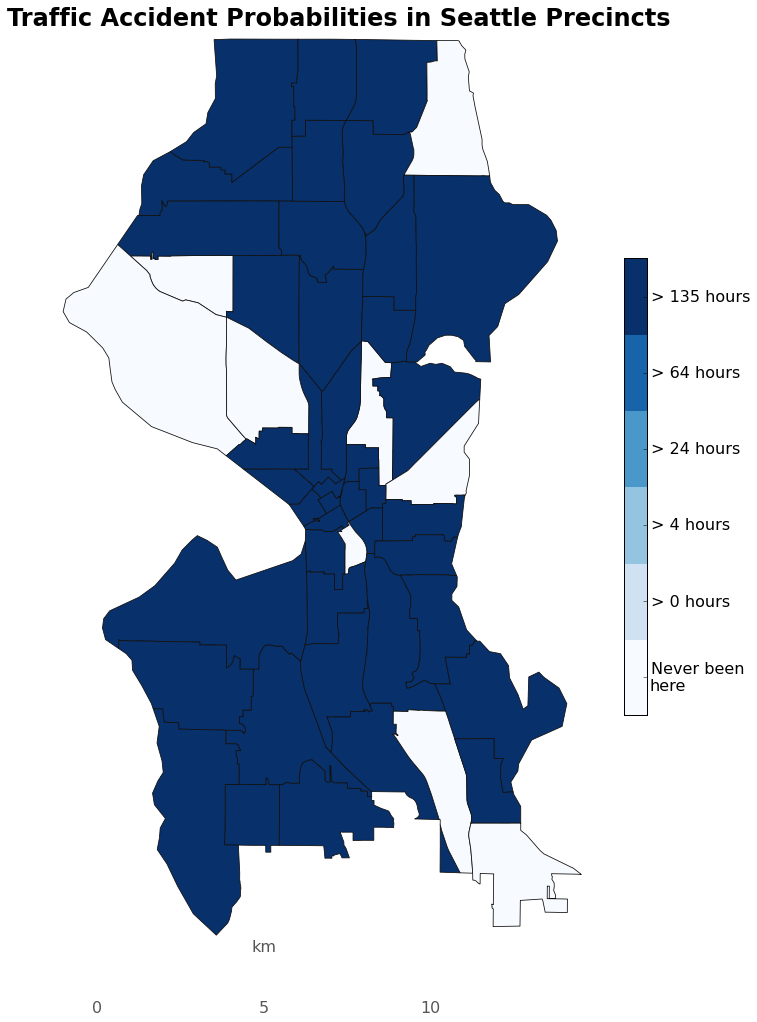

In [29]:
# Check out the full post at http://beneathdata.com/how-to/visualizing-my-location-history/
# to utilize the code below

# We'll only use a handful of distinct colors for our choropleth. So pick where
# you want your cutoffs to occur. Leave zero and ~infinity alone.
#breaks = [1.] + [20., 40., 60., 80.] + [100.]
breaks = [0.] + [4., 24., 64., 135.] + [1e20]
def self_categorize(entry, breaks):
    for i in range(len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return -1
df_map['jenks_bins'] = df_map.hood_hours.apply(self_categorize, args=(breaks,))

jenks_labels = ['Never been\nhere']+["> %d hours"%(perc) for perc in breaks[:-1]]

# Or, you could always use Natural_Breaks to calculate your breaks for you:
# from pysal.esda.mapclassify import Natural_Breaks
# breaks = Natural_Breaks(df_map[df_map['hood_hours'] > 0].hood_hours, initial=300, k=3)
# df_map['jenks_bins'] = -1 #default value if no data exists for this bin
# df_map['jenks_bins'][df_map.hood_count > 0] = breaks.yb
# 
# jenks_labels = ['Never been here', "> 0 hours"]+["> %d hours"%(perc) for perc in breaks.bins[:-1]]

def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar

figwidth = 14
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

cmap = plt.get_cmap('Blues')
# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# apply our custom color values onto the patch collection
cmap_list = [cmap(val) for val in (df_map.jenks_bins.values - df_map.jenks_bins.values.min())/(
                  df_map.jenks_bins.values.max()-float(df_map.jenks_bins.values.min()))]
pc.set_facecolor(cmap_list)
ax.add_collection(pc)

#Draw a map scale
m.drawmapscale(coords[0] + 0.08, coords[1] + -0.01,
    coords[0], coords[1], 10.,
    fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5, ax=ax,)

# ncolors+1 because we're using a "zero-th" color
cbar = custom_colorbar(cmap, ncolors=len(jenks_labels)+1, labels=jenks_labels, shrink=0.5)
cbar.ax.tick_params(labelsize=16)

fig.suptitle("Traffic Accident Probabilities in Seattle Precincts", fontdict={'size':24, 'fontweight':'bold'}, y=0.92)
#ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
#ax.text(1.35, 0.04, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
#    ha='right', color='#555555', style='italic', transform=ax.transAxes)
#ax.text(1.35, 0.01, "BeneathData.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)
#x, y = m(df['longitude'].values, df['latitude'].values)
#m.plot(x, y, 'bo', markersize=10)
#plt.savefig('chloropleth.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

In [14]:
df_map

,name,poly,hood_hours,jenks_bins,patches
0,B1,"POLYGON ((2873.939633525799 20568.7074135003, ...",12,1,"Poly((2873.94, 20568.7) ...)"
1,B2,"POLYGON ((5816.9672314251 20584.70221379053, 5...",69,3,"Poly((5816.97, 20584.7) ...)"
2,B3,"POLYGON ((7934.48155884745 19773.15262858152, ...",97,3,"Poly((7934.48, 19773.2) ...)"
3,C1,"POLYGON ((9830.783643657869 13710.27170494595,...",32,2,"Poly((9830.78, 13710.3) ...)"
4,E1,"POLYGON ((9617.362826019662 14272.66043763677,...",14,1,"Poly((9617.36, 14272.7) ...)"
5,C2,"POLYGON ((10837.46406775929 17292.37886774639,...",25,2,"Poly((10837.5, 17292.4) ...)"
6,D2,"POLYGON ((7898.496811817784 14327.21371633085,...",36,2,"Poly((7898.5, 14327.2) ...)"
7,C3,"POLYGON ((12231.84072768402 13474.05937480063,...",10,1,"Poly((12231.8, 13474.1) ...)"
8,D1,"POLYGON ((6073.702729911579 14201.90891658106,...",19,1,"Poly((6073.7, 14201.9) ...)"
9,D3,"POLYGON ((8548.283447383646 13895.81824377246,...",82,3,"Poly((8548.28, 13895.8) ...)"


In [15]:
df

,latitude,longitude,val
0,47.668675,-122.382131,12
1,47.660512,-122.356103,69
2,47.661384,-122.338565,97
3,47.626826,-122.320221,32
4,47.633594,-122.301596,14
5,47.612940,-122.296200,25
6,47.614695,-122.348747,36
7,47.618544,-122.341373,10
8,47.623699,-122.330440,19
9,47.618487,-122.325287,82
